# Final Year Project - Intelligent Health Monitoring System
#### by: Koo Chia Meng, A0165275Y

### DATA ANALYSIS
### Correlation in Health Improvements:
### Activity (Number of Steps, Hours of exercise) VS HRV

The following will be done in this Notebook:
1. Exploring the correlation between the parameters given by health trackers and improvement in health.
    - The difference in Activity (Number of steps) are correlated with the improve in Heart Health (HRV)?
        
2. How to justify Health improvements:
    - Decrease / increase in certain heatlth indicators as used in multiple health studies.

### Importing both person data

In [1]:
#Import relevant Dependencies

import datetime
import time
import pandas as pd # Pandas Version 1.0.5
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats as sps
import sklearn.linear_model as lm
import seaborn as sns # use for visualising
import os

In [2]:
%run FYP_SUBJECTS_CLASS.ipynb # line needed to reuse the SUBJECT class created for OOP

### Loading Subjects from PICKLE

In [3]:
current_directory = os.getcwd()
folder = "PERSON1" # CHANGE HERE
file = "PERSON1_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON1 = pickle.load(file=f)

In [4]:
PERSON1.profile

{'age': 28, 'gender': 'MALE', 'height': 170.0, 'weight': 75.0}

In [5]:
current_directory = os.getcwd()
folder = "PERSON2" # CHANGE HERE
file = "PERSON2_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON2 = pickle.load(file=f)

In [6]:
PERSON2.profile

{'age': 27, 'gender': 'MALE', 'height': 176.0, 'weight': 65.0}

### Loading Previously Processed DFs from PICKLE

In [7]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON1.df_resting_hr = unpickle['df_resting_hr']
PERSON1.df_hr_calories = unpickle['df_hr_calories']
PERSON1.df_intraday_hr = unpickle['df_intraday_hr']
PERSON1.df_sleep_durations = unpickle['df_sleep_durations']
PERSON1.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON1.df_activity_steps = unpickle['df_activity_steps']
PERSON1.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON1.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON1.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']


In [8]:
current_directory = os.getcwd()
folder = os.path.join("PERSON2","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON2.df_resting_hr = unpickle['df_resting_hr']
PERSON2.df_hr_calories = unpickle['df_hr_calories']
PERSON2.df_intraday_hr = unpickle['df_intraday_hr']
PERSON2.df_sleep_durations = unpickle['df_sleep_durations']
PERSON2.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON2.df_activity_steps = unpickle['df_activity_steps']
PERSON2.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON2.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON2.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']

In [9]:
PERSON_LIST = [PERSON1,PERSON2] # Declare a list of person to create

### CORRELATION PLOTS

In [15]:
hrv_cols = ['Mean_PP_interval','PP_interval_range',
            'SD_PP_interval','SD_PP_5min','RMS_PP_diff',
            'Max_PP_1st_dydt','Max_PP_2nd_dydt']

VeryActive_col = ['minutes_Cardio', 'minutes_Peak']


In [55]:
# Calculating the total duartion when HR is in Peak & Cardio Levels (very active / High HeartRate)
list_active =[]

for i, subject in enumerate(PERSON_LIST):
    df_process = pd.concat([subject.df_activity_steps.step_count,
                                  subject.df_hr_calories[VeryActive_col].sum(axis=1)],
                                axis=1 ).dropna()
    df_process.columns = ['step_count','very_active_minutes']
    df_process.index.name = 'date'
    list_active.append(df_process)
    
list_active

[            step_count  very_active_minutes
 date                                       
 2020-02-21     12981.0                 31.0
 2020-02-22     12802.0                  0.0
 2020-02-23      9030.0                  0.0
 2020-02-24     15361.0                  0.0
 2020-02-25     12570.0                 19.0
 ...                ...                  ...
 2020-07-27     14356.0                  0.0
 2020-07-28      8149.0                  0.0
 2020-07-29     13651.0                 14.0
 2020-07-30     10888.0                  0.0
 2020-07-31      9727.0                  0.0
 
 [114 rows x 2 columns],
             step_count  very_active_minutes
 date                                       
 2020-04-06      8208.0                 20.0
 2020-04-07      6070.0                  0.0
 2020-04-08      9494.0                 13.0
 2020-04-09      4849.0                  0.0
 2020-04-16      4406.0                 17.0
 ...                ...                  ...
 2020-07-26      7048.0     


PERSON 1: 


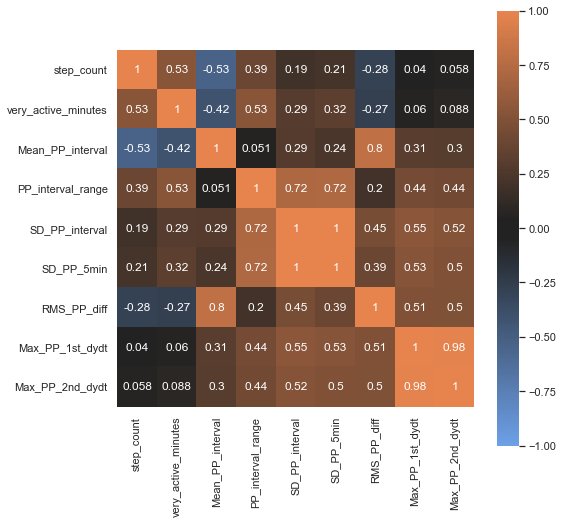


PERSON 2: 


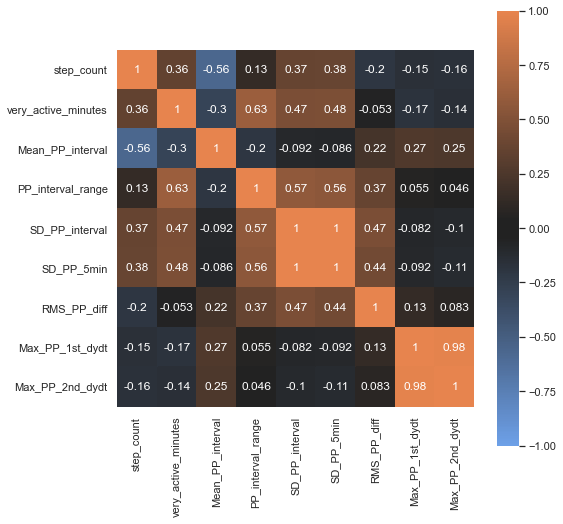

In [56]:
activity_col = ['step_count','very_active_minutes']

for i, subject in enumerate(PERSON_LIST):

    print('\nPERSON {}:'.format(i+1),'\n'+'='*10)
    
    DATA = pd.concat([list_active[i][activity_col],subject.df_hrv_stats_full_day[hrv_cols]]
                    , axis=1)
 
    sns.set(rc={'figure.figsize':(8,8)})

    CMAP = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True) # define the color scheme

    sns.heatmap(DATA.corr(),vmin=-1.0,vmax=1.0,cmap=CMAP,annot=True, square=True)

    plt.show()


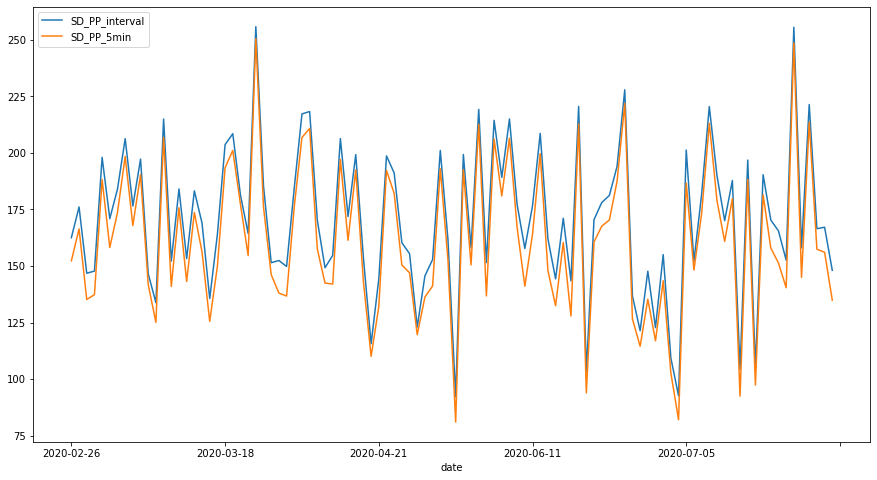

In [18]:
PERSON1.df_hrv_stats_full_day[['SD_PP_interval','SD_PP_5min']].plot(figsize=(15,8))

In [19]:
PERSON1.df_hrv_stats_full_day[['SD_PP_interval','SD_PP_5min']].corr()

,SD_PP_interval,SD_PP_5min
SD_PP_interval,1.000000,0.997012
SD_PP_5min,0.997012,1.000000


SD_PP_5min is the SD of the PP intervals grouped in 5 minutes. The correlation is very close to 1, thus shows as 1 in the Heatmap.

From the Heat map (first 2 columns) above, it is shown that: 

The Number of Steps and Very active miuntes are correlated with: 

(Positive)
- PP_Interval_Range -> the range of PP intervals (Max - Min)
- SD_PP_Interval -> Standard Deviation of Pulse to Pulse intervals
- SD_PP_5mins -> Standard Deviation of Pulse to Pulse intervals of 5 mins groupings

(Negative)
- Mean_PP_Interval -> Average Pulse to Pulse interval
- RMS_PP_diff -> RMS for successive Pulse to Pulse interval


#### Using Z-Score to Find Outliers

In [59]:
# Z Score can be used to find outliers if the data is a normal distribution:
# if z-score value is more than 3, the point is most likely an outlier.
# Zscore tells us how far away (in the ratio of SD) the record is away from the mean.

list_plot = [] # define empt list to store DF for plotting later.

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    for col_y in activity_col:
        for col in hrv_cols:
            # INPUT X & Y SERIES:
            x_plot = list_active[i][col_y].copy()
            y_plot = subject.df_hrv_stats_full_day[col].copy()

            # Finding Z-Score & Setting Date as index:
            x_plot = pd.concat([x_plot.reset_index(),pd.Series(sps.zscore(x_plot))],axis=1)
            x_plot = x_plot.rename(columns={0:'z_score'}).set_index('date')

            y_plot = pd.concat([y_plot.reset_index(),pd.Series(sps.zscore(y_plot))],axis=1)
            y_plot = y_plot.rename(columns={0:'z_score'}).set_index('date')

            new_x_plot = x_plot[(x_plot.z_score<=3) & (x_plot.z_score>=-3)]
            new_y_plot = y_plot[(y_plot.z_score<=3) & (y_plot.z_score>=-3)]

            # Match all points and Save into Dict to prep for Seaborn plotting:
            DATA_after = pd.concat([new_x_plot.drop(columns=['z_score']),new_y_plot.drop(columns=['z_score'])],axis=1).dropna()

            list_plot.append(DATA_after)


PERSON 1: 


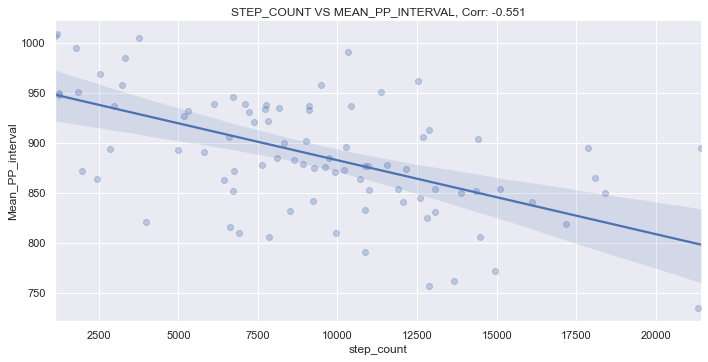

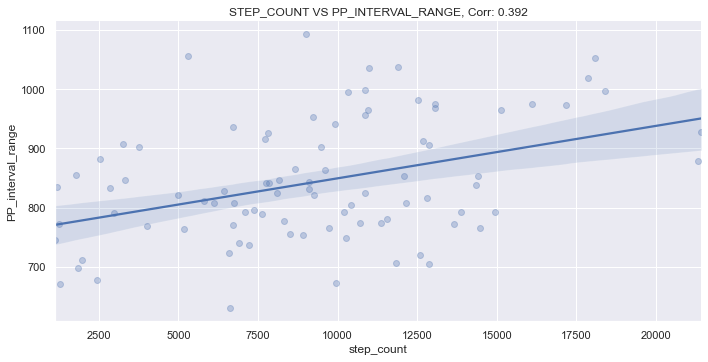

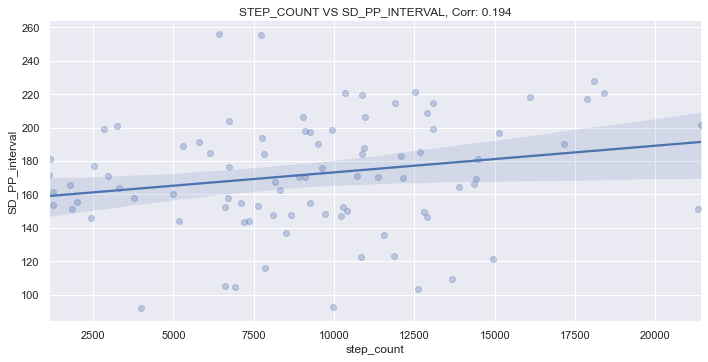

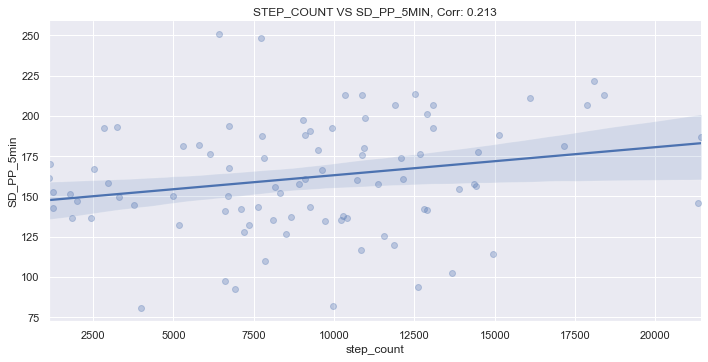

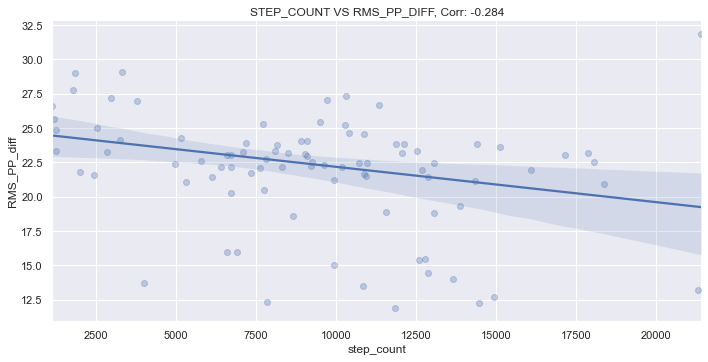

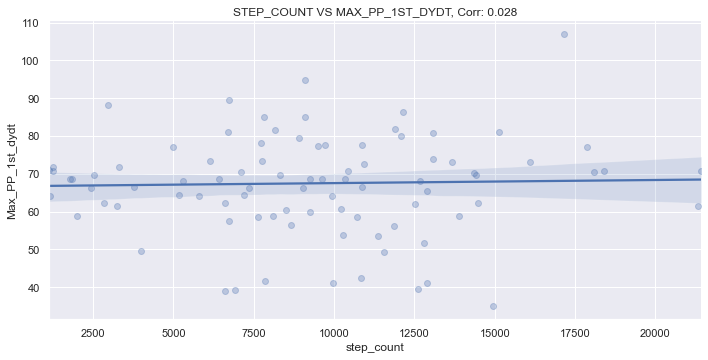

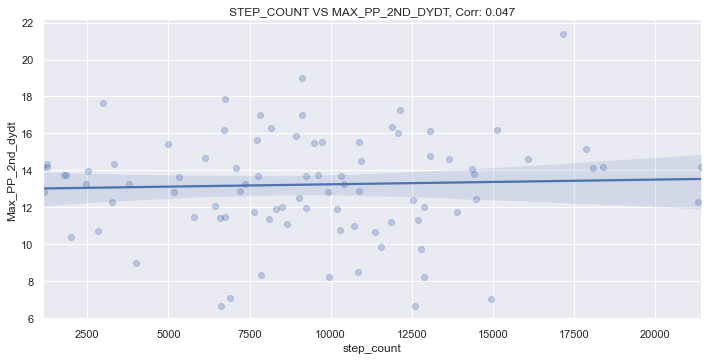


PERSON 2: 


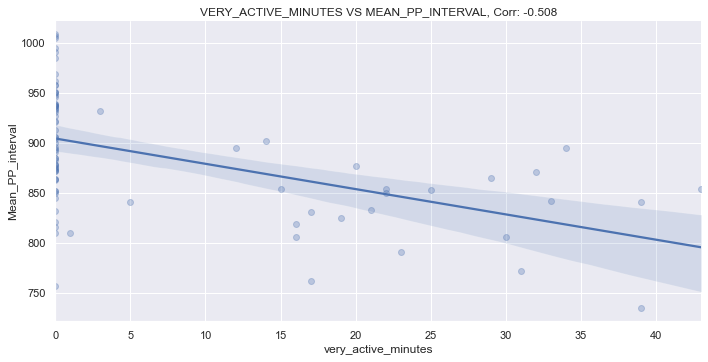

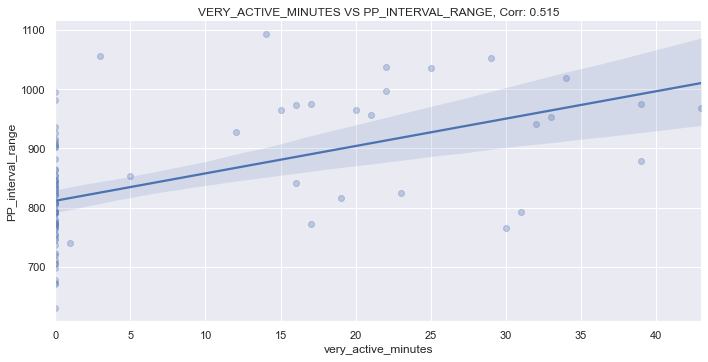

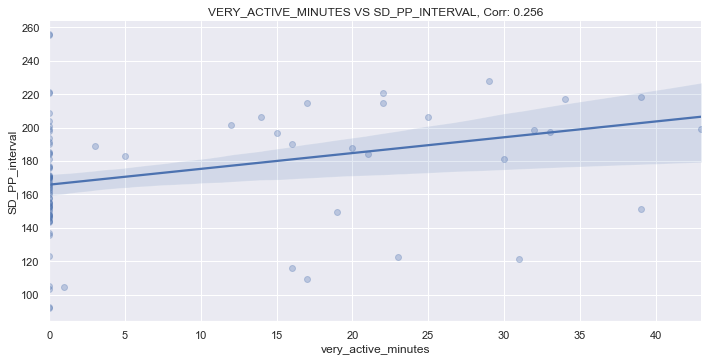

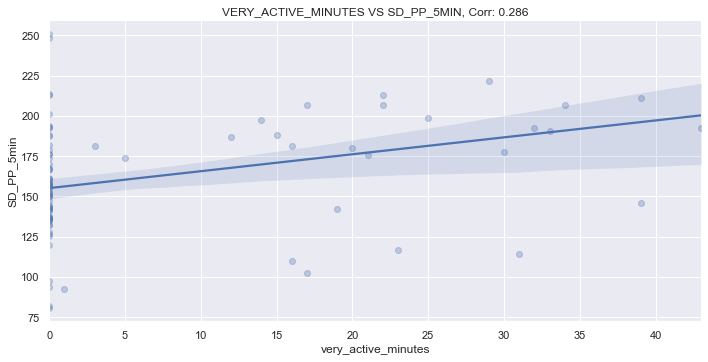

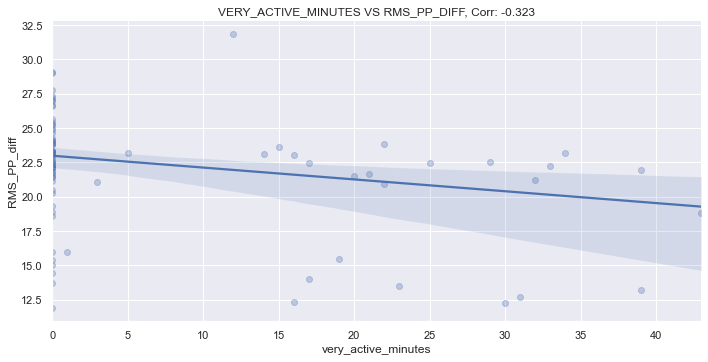

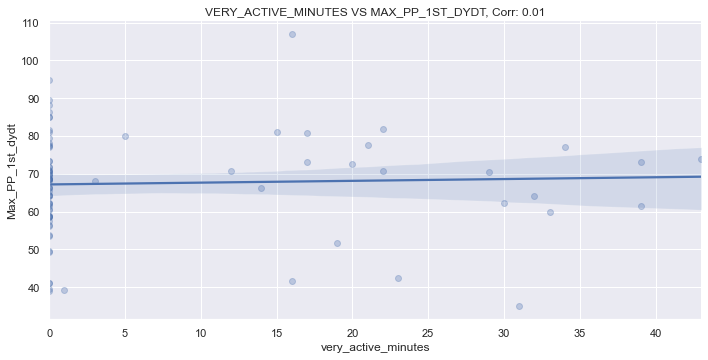

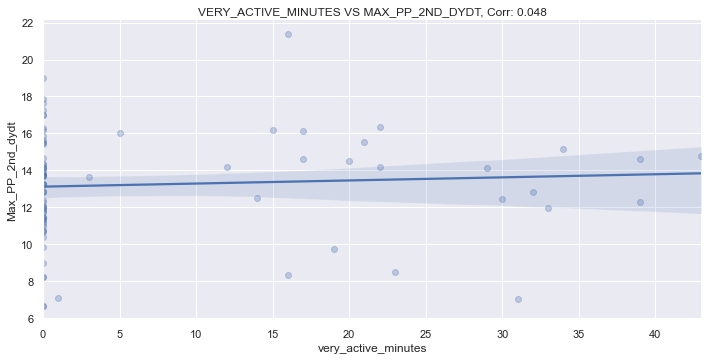

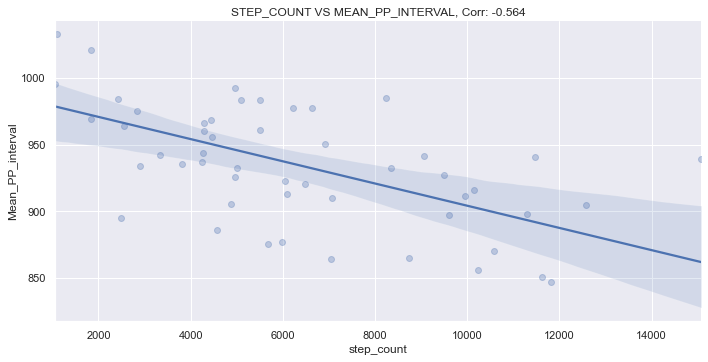

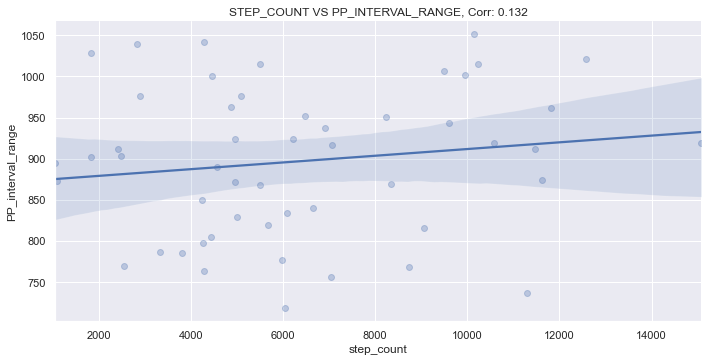

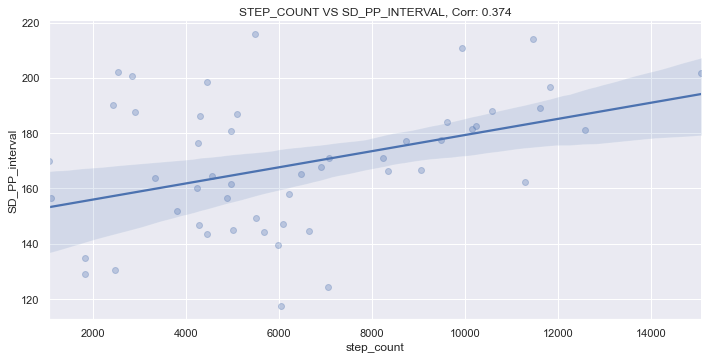

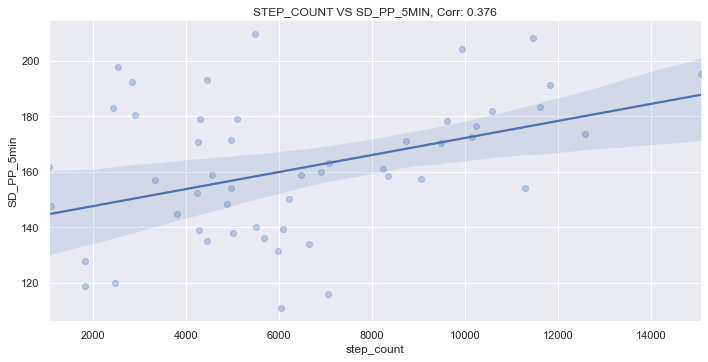

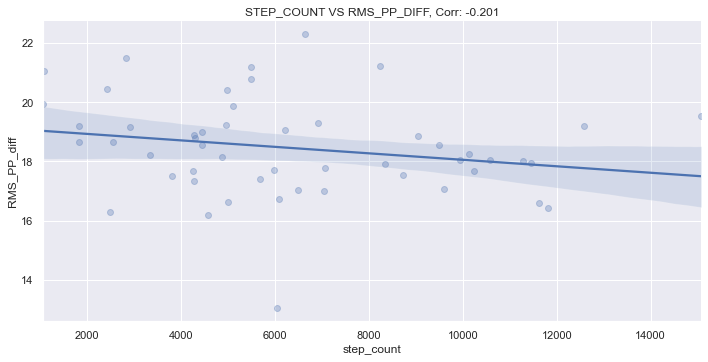

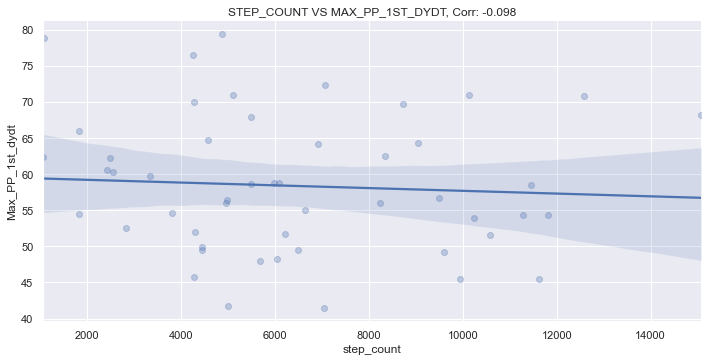

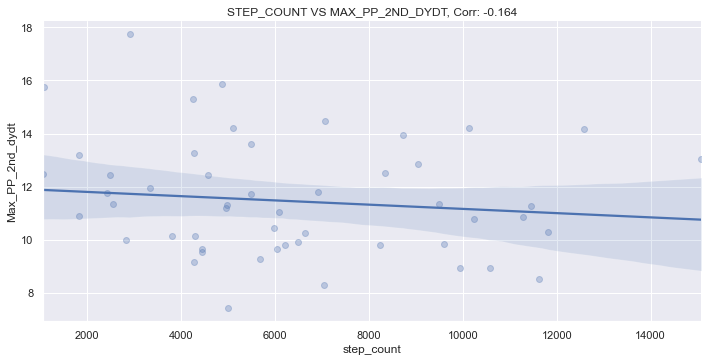

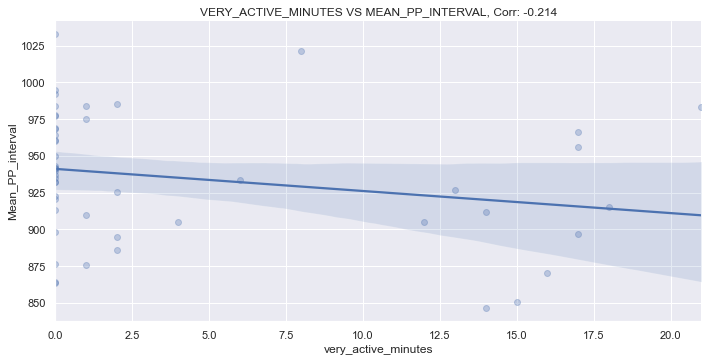

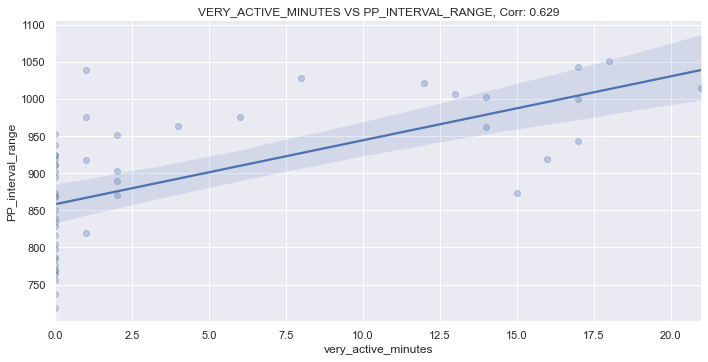

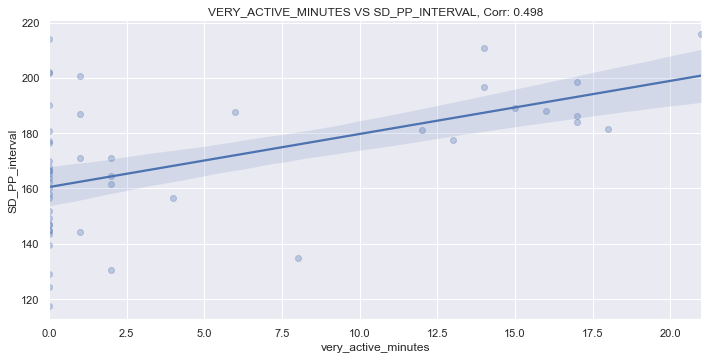

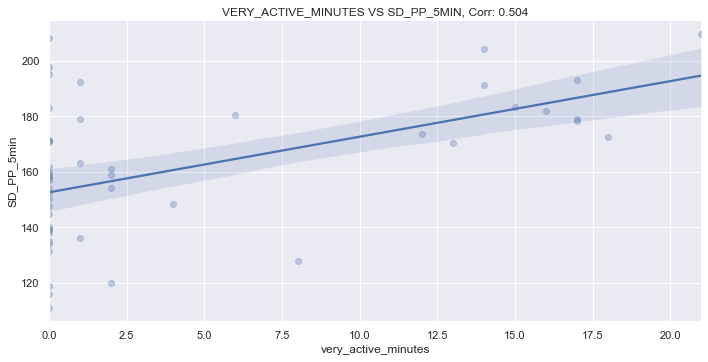

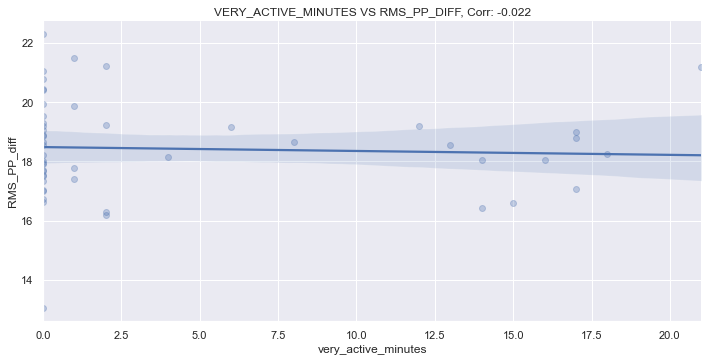

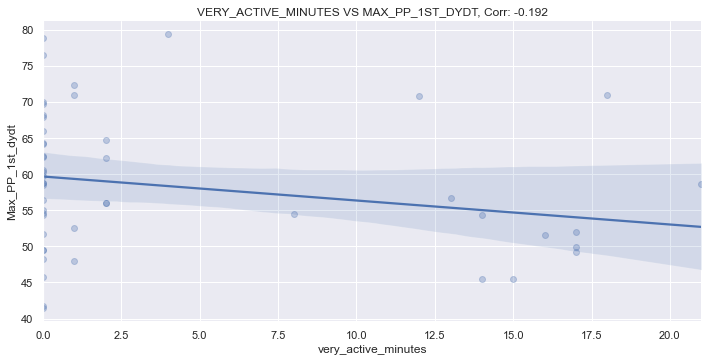

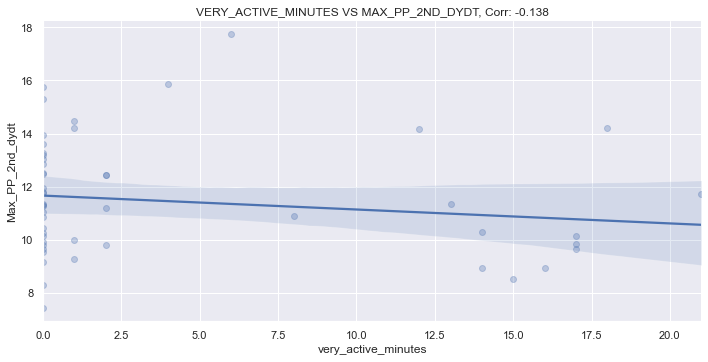

In [60]:
# Seaborn Scatter Plot for linear regression:

for i, DATA in enumerate(list_plot): # applying the same steps for PERSON1 and PERSON2.
    if i == 0:
        num = 1
        print('\nPERSON {}:'.format(1),'\n'+'='*10)
    elif i == len(hrv_cols)*len(activity_col):
        num = num + 1
        print('\nPERSON {}:'.format(num),'\n'+'='*10)
        
    sns.lmplot(DATA.columns[0],DATA.columns[1],data=DATA,robust=True,aspect=2,scatter_kws={'alpha':0.3})

    # Finding Correlation:
    Corr_value = DATA.corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
    plt.title(str(DATA.columns[0]).upper()+' VS '+str(DATA.columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

    plt.show()


#### Using IQR to Exclude Outliers

In [64]:
# Excluding outliers (outside of 3*IQR)

list_plot = [] # define empt list to store DF for plotting later.

for i, subject in enumerate(PERSON_LIST): # applying the same steps for PERSON1 and PERSON2.
    for col_y in activity_col:
        for col in hrv_cols:
            # INPUT X & Y SERIES:
            x_plot = list_active[i][col_y].copy()
            y_plot = subject.df_hrv_stats_full_day[col].copy()

            # Finding the inter-quantile range (IQR) between 25th and 75th percentile:

            # For X:
            X_Q1 = np.percentile(x_plot,25)
            X_Q3 = np.percentile(x_plot,75)
            X_IQR = X_Q3 - X_Q1

            # For Y:
            Y_Q1 = np.percentile(y_plot,25)
            Y_Q3 = np.percentile(y_plot,75)
            Y_IQR = Y_Q3 - Y_Q1

            # Finding the points outside of 1.5*IQR from Q1 and Q3
            new_x_plot = x_plot[(x_plot >= X_Q1-1.5*X_IQR) & (x_plot <= X_Q3+1.5*X_IQR)]
            new_y_plot = y_plot[(y_plot >= Y_Q1-1.5*Y_IQR) & (y_plot <= Y_Q3+1.5*Y_IQR)]

            # Match all points and Save into Dict to prep for Seaborn plotting:
            DATA_after = pd.concat([new_x_plot,new_y_plot],axis=1).dropna()

            list_plot.append(DATA_after)


PERSON 1: 


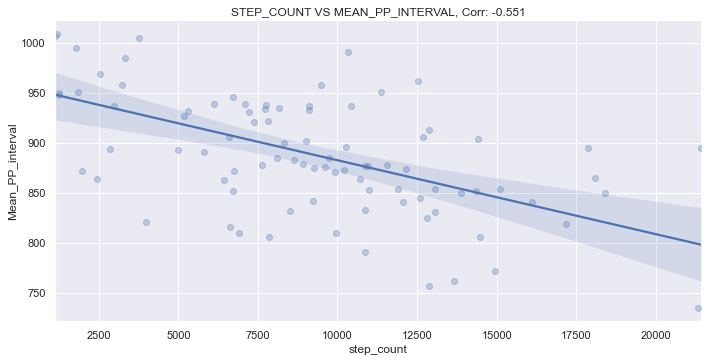

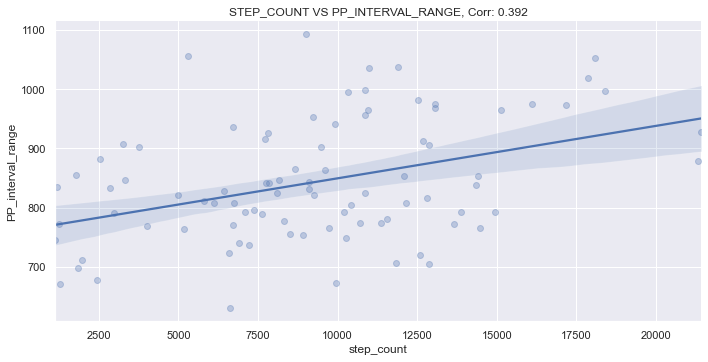

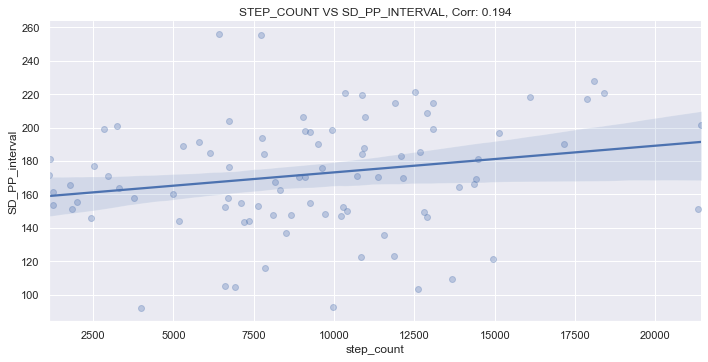

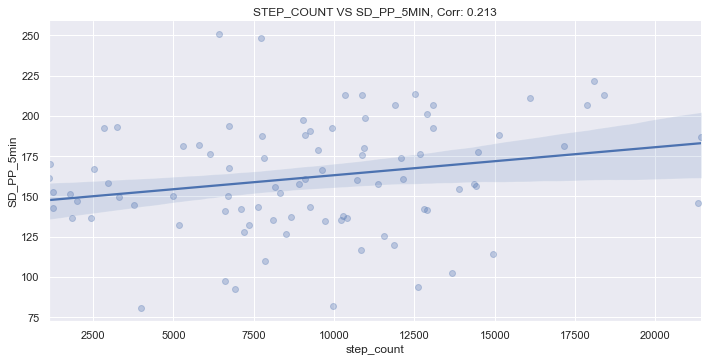

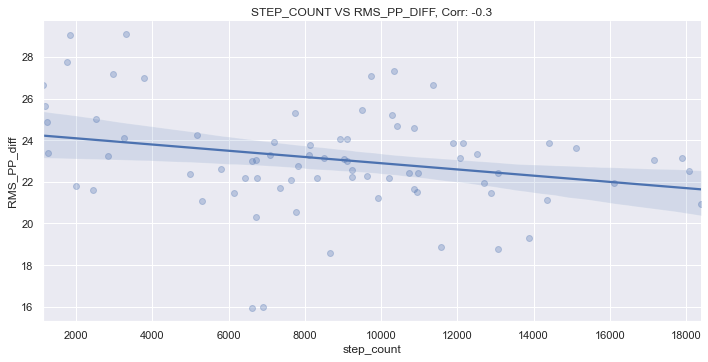

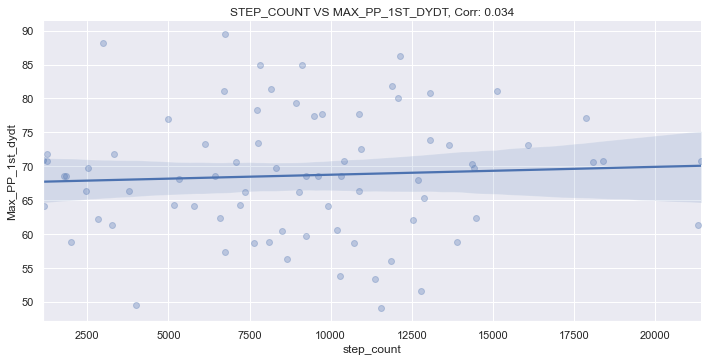

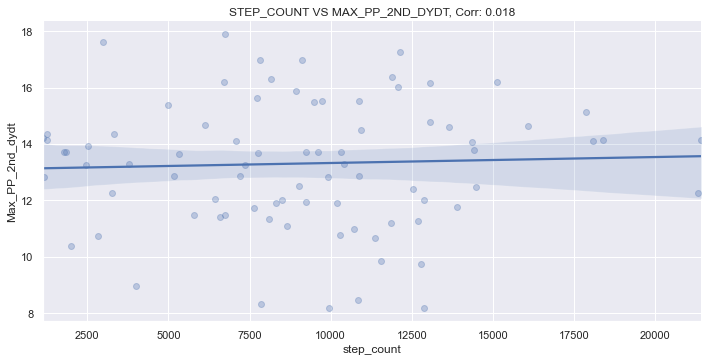


PERSON 2: 


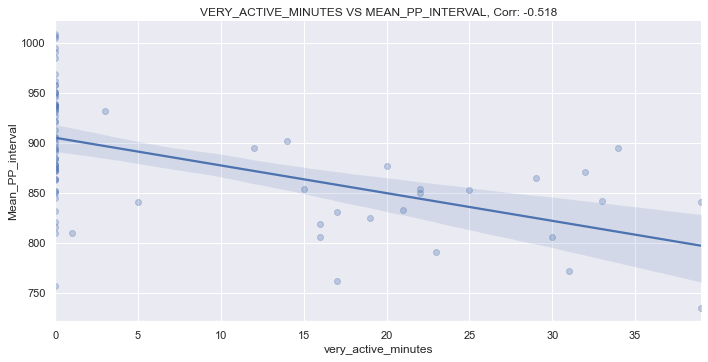

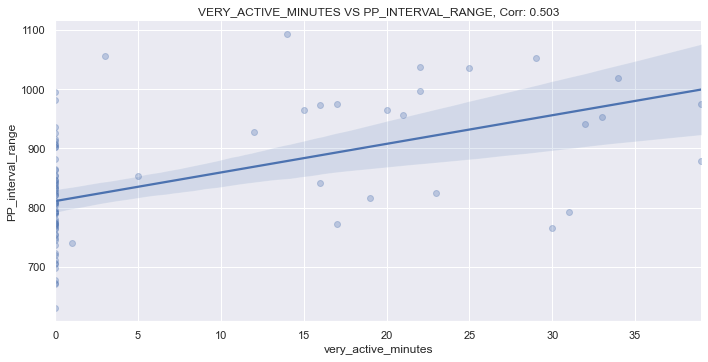

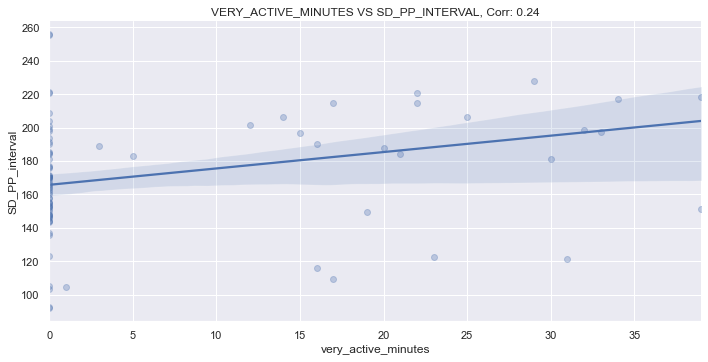

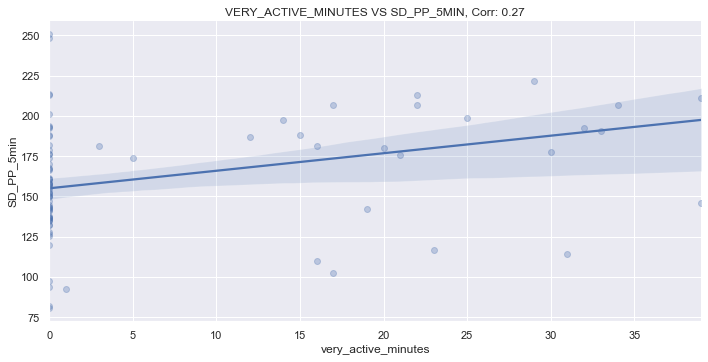

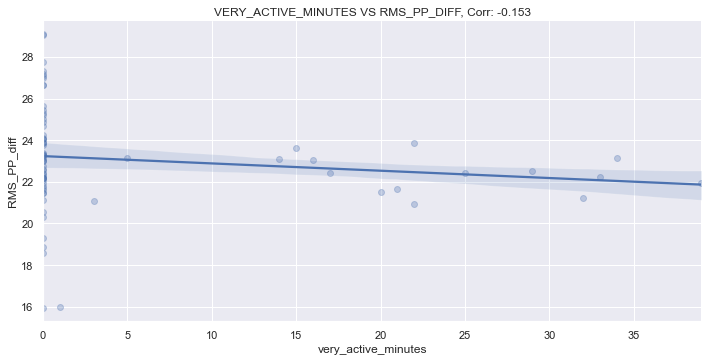

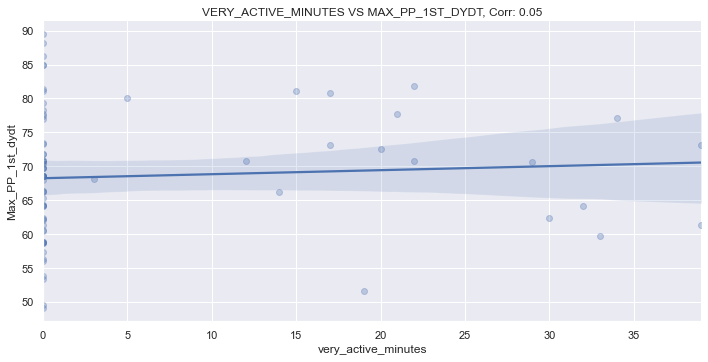

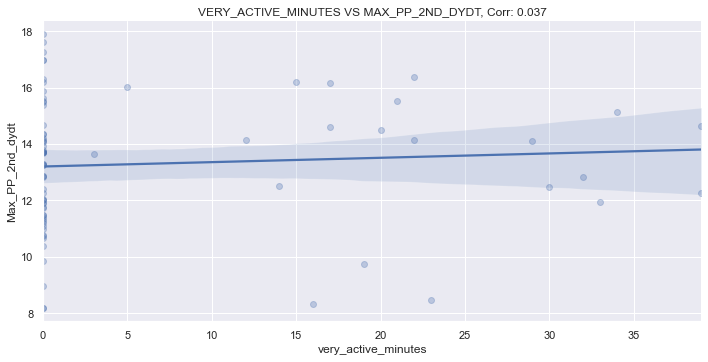

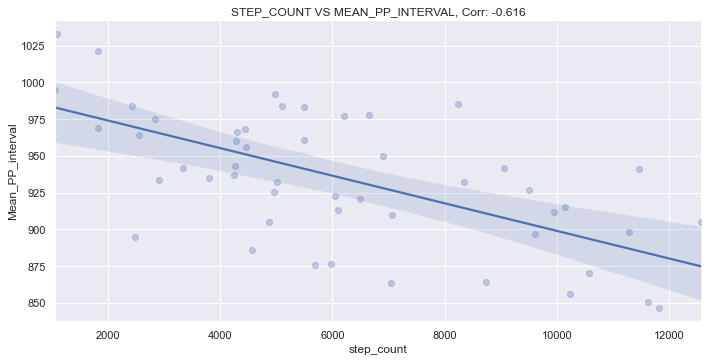

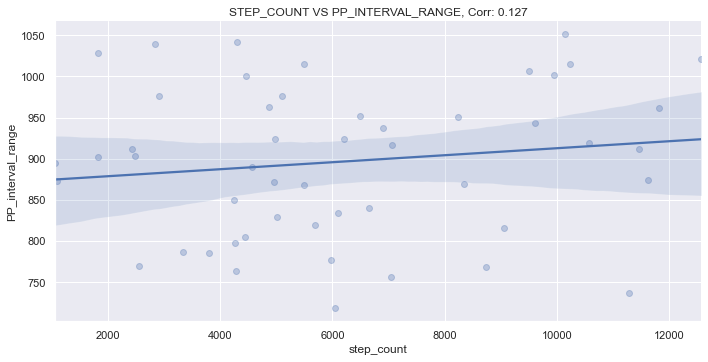

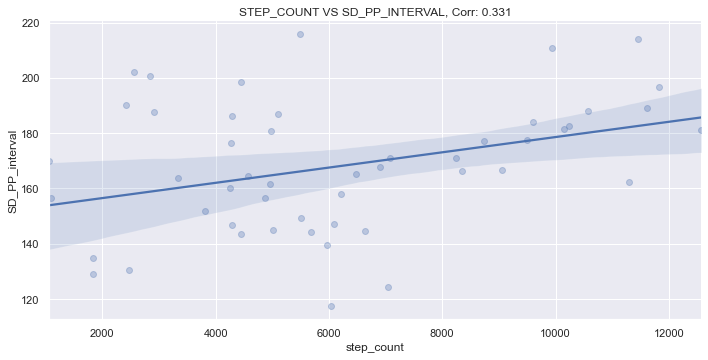

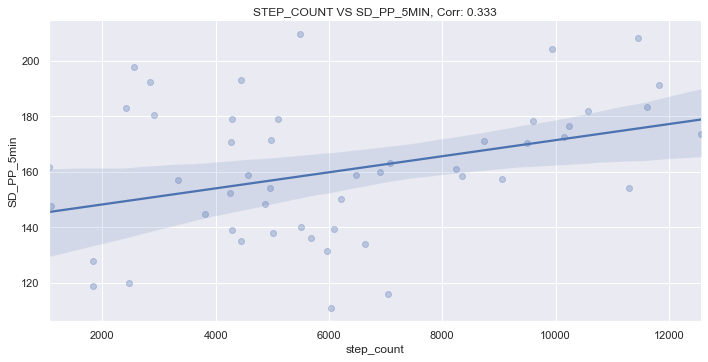

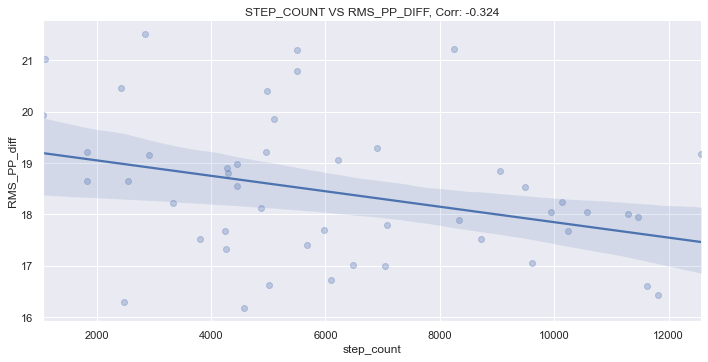

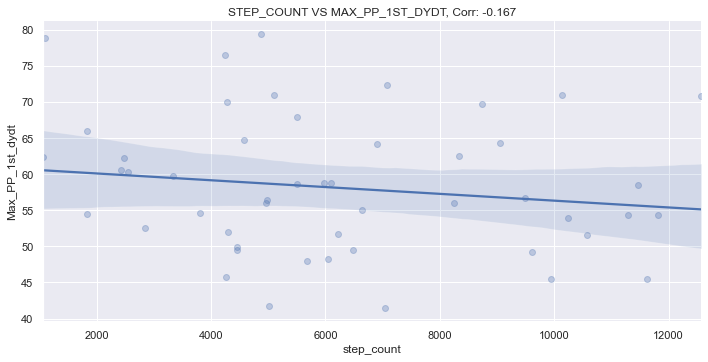

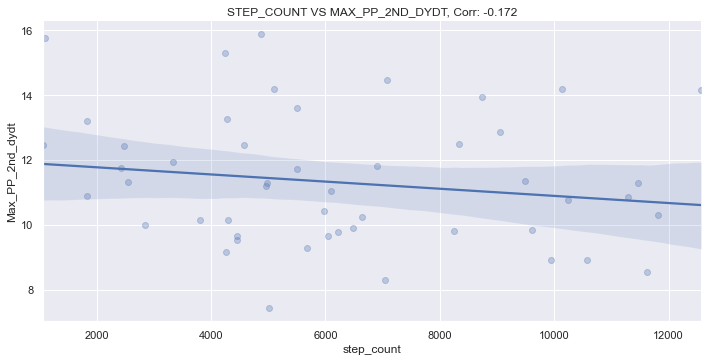

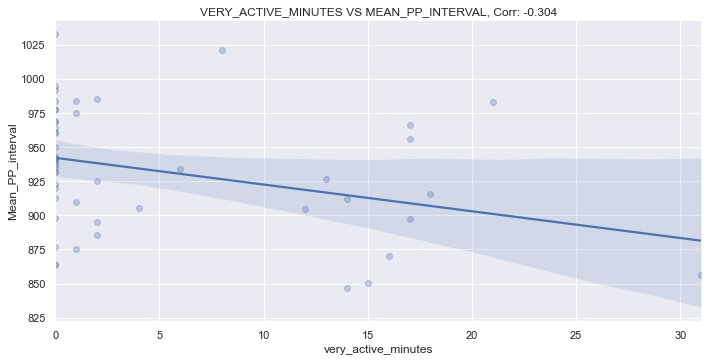

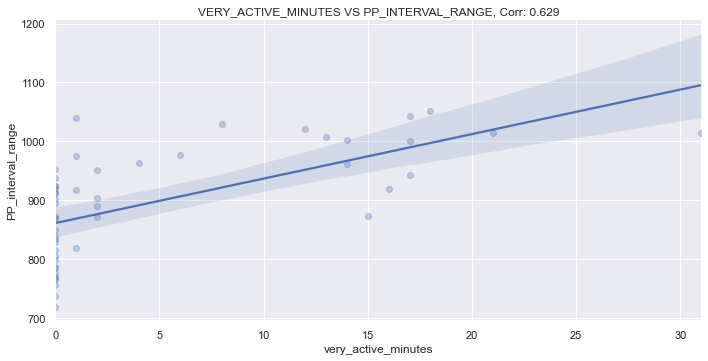

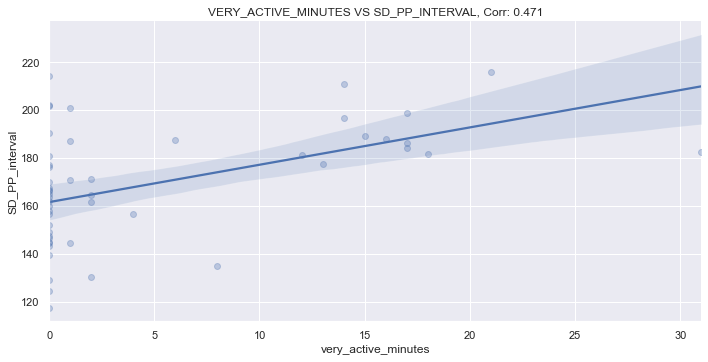

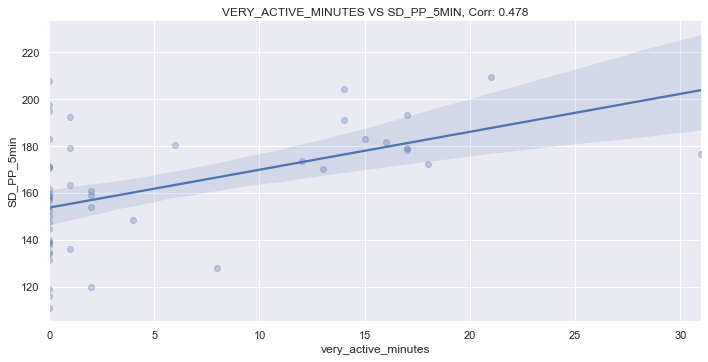

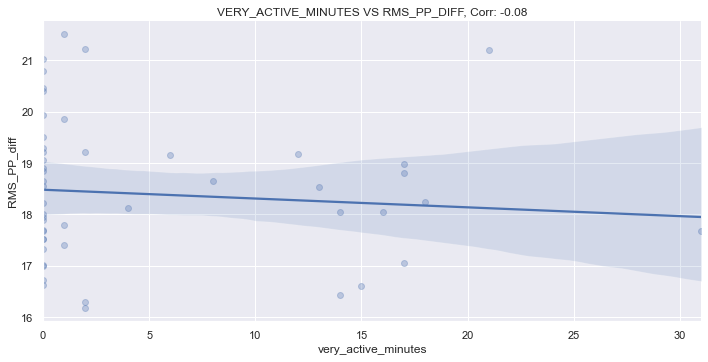

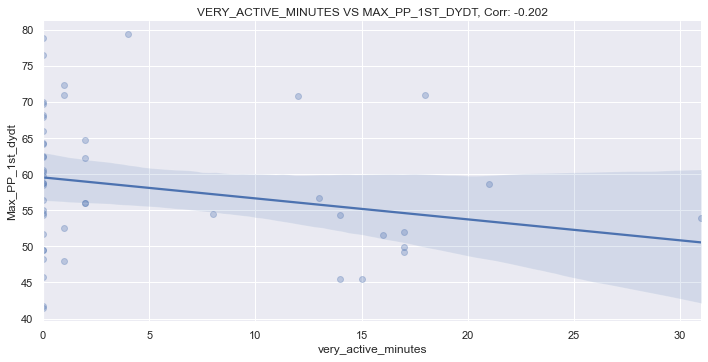

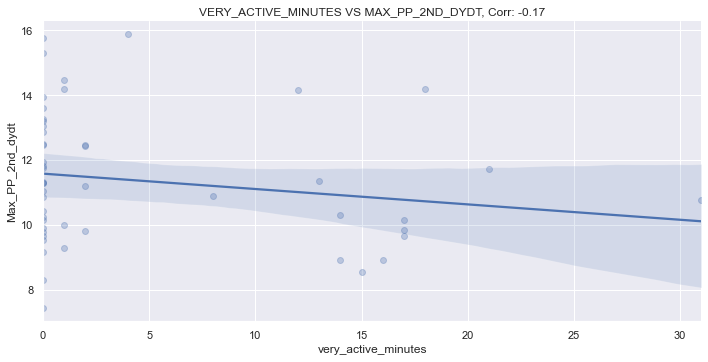

In [65]:
# Seaborn Scatter Plot for linear regression:
num = 0
for i, DATA in enumerate(list_plot): # applying the same steps for PERSON1 and PERSON2.
    if i == 0 or i == len(hrv_cols)*len(activity_col):
        num = num + 1
        print('\nPERSON {}:'.format(num),'\n'+'='*10)
    
    sns.lmplot(DATA.columns[0],DATA.columns[1],data=DATA,robust=True,aspect=2,scatter_kws={'alpha':0.3})

    # Finding Correlation:
    Corr_value = DATA.corr().iloc[0,1] # the .corr() method returns a matrix of corr values.
    plt.title(str(DATA.columns[0]).upper()+' VS '+str(DATA.columns[1]).upper()+', Corr: '+ str(round(Corr_value,3)))

    plt.show()


As shown in the above plots, the correlation for and Activity with:
- Mean PP interval was significantly Negative for both, Thus is Positively related to Heart Rate. 
    - As exercise increased, HR increases.
- PP interval range was Positive for both person
    - More variability when more active.
- SD PP Interval and SD in 5 min grouping was Positive for both person
- RMS successive difference is Negative for both person
- Max 1st and 2nd Derivative of PP intervals was negligible / undertermined.
    - The rate of change of PP interval or Heart Rate may not be dependent on activity level

### Difference between using IQR and Z-Score to find outliers

The difference between the above two methods is that IQR follows the percentiles which is not dependent on the "Shape" of distribution. Whereas Z-score calculates how many SD away a point is from the Mean value as the center value. Thus it may produce more outliers is the dataset is skewed to either side, it also means that the distribution has to be "Normal". In this case, using IQR would be better as the distribution may not be necessary Normal.

In conclusion, Having high number of steps and more cardio activity can improve the heart health.